In [ ]:
#| default_exp opt/visualize

In [ ]:
from translucid.opt import *
import torch, torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
#| export
import torch.optim as opt
import matplotlib.pyplot as plt
import torchvision.transforms as T
from fastprogress import progress_bar
import fastcore.all as fc
from translucid.param.image import *

In [ ]:
#| export
class Visualizer:
    def __init__(self, model, obj, target: ImageParam, optim=opt.Adam, tfms=None):
        self.model, self.obj, self.target, self.optim = model, obj, target, optim
        self.tfms = tfms or default_transforms(target.orig_shape[-1])
        if not callable(self.tfms): self.tfms = T.Compose(self.tfms)
    
    def visualize(self, x: ImageParam = None, lr = 5e-2, n_iter = 1000, mb=None, param_kwargs=None):
        _x = fc.ifnone(x, self.target)
        optim = self.optim([_x], lr=lr)
        
        pb = progress_bar(range(n_iter), parent=mb)
        for i in pb:
            optim.zero_grad()
            x = self.prep_x(_x, param_kwargs)
            loss = self.obj(self.model, x)
            loss.backward()
            optim.step()
            pb.comment = f'Loss: {loss.item()/len(x)}'
            if i % 100 == 0:
                print(f'Iteration {i}, loss: {loss.item()/len(x)}')
        return _x
    
    def prep_x(self, x, param_kwargs=None):
        if isinstance(x, ImageParam): x = x.to_img(**(param_kwargs or {}))
        return self.tfms(x)

In [ ]:
#| export
def to_inception_tf(img): return img * 255 - 117

def to_inception():
    return T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
layer = 'inception4a'
model = models.googlenet(weights='IMAGENET1K_V1')
model = model.eval()
model = model.to('cuda')

In [ ]:
obj = sum(channel(layer, i, batch=i) for i in range(10))
x = ImageParam.new((10,3, 224, 224), fft=True, decorr=True)
tfms = default_transforms(224) + [to_inception()]

vis = Visualizer(model, obj, x, tfms = tfms)

In [ ]:
res = vis.visualize(n_iter=1000, param_kwargs={'dp':1})

Iteration 0, loss: -17.78151092529297
Iteration 100, loss: -15.965426635742187
Iteration 200, loss: -16.626158142089842
Iteration 300, loss: -16.240876770019533
Iteration 400, loss: -29.16075439453125
Iteration 500, loss: -10.405332946777344
Iteration 600, loss: -15.120103454589843
Iteration 700, loss: -8.836415863037109
Iteration 800, loss: -24.523162841796875
Iteration 900, loss: -27.512142944335938


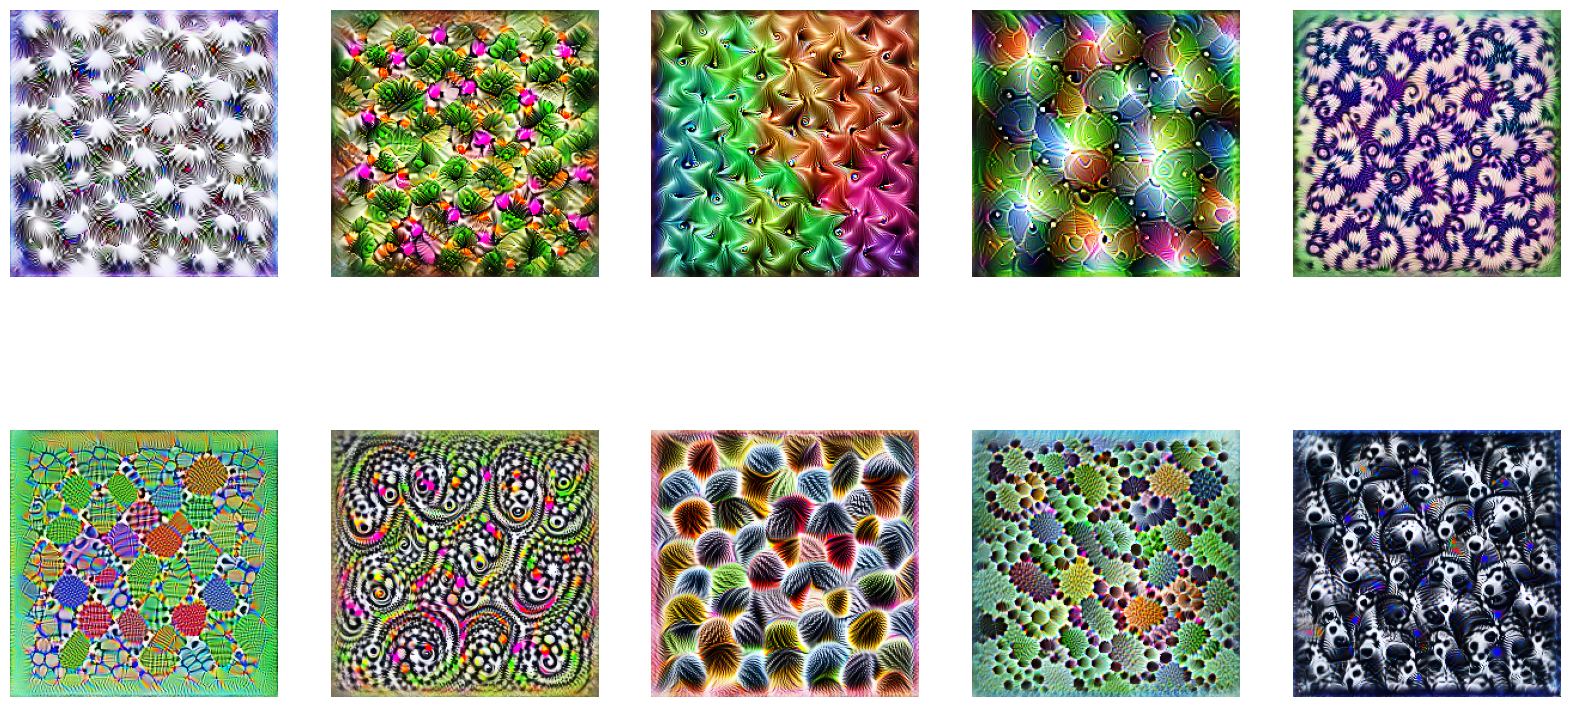

In [ ]:
axes = plt.subplots(2,5, figsize=(20,10))[1].flatten()
for i, ax in enumerate(axes):
    res[i].show(ax=ax, dp=1)
    ax.axis('off')

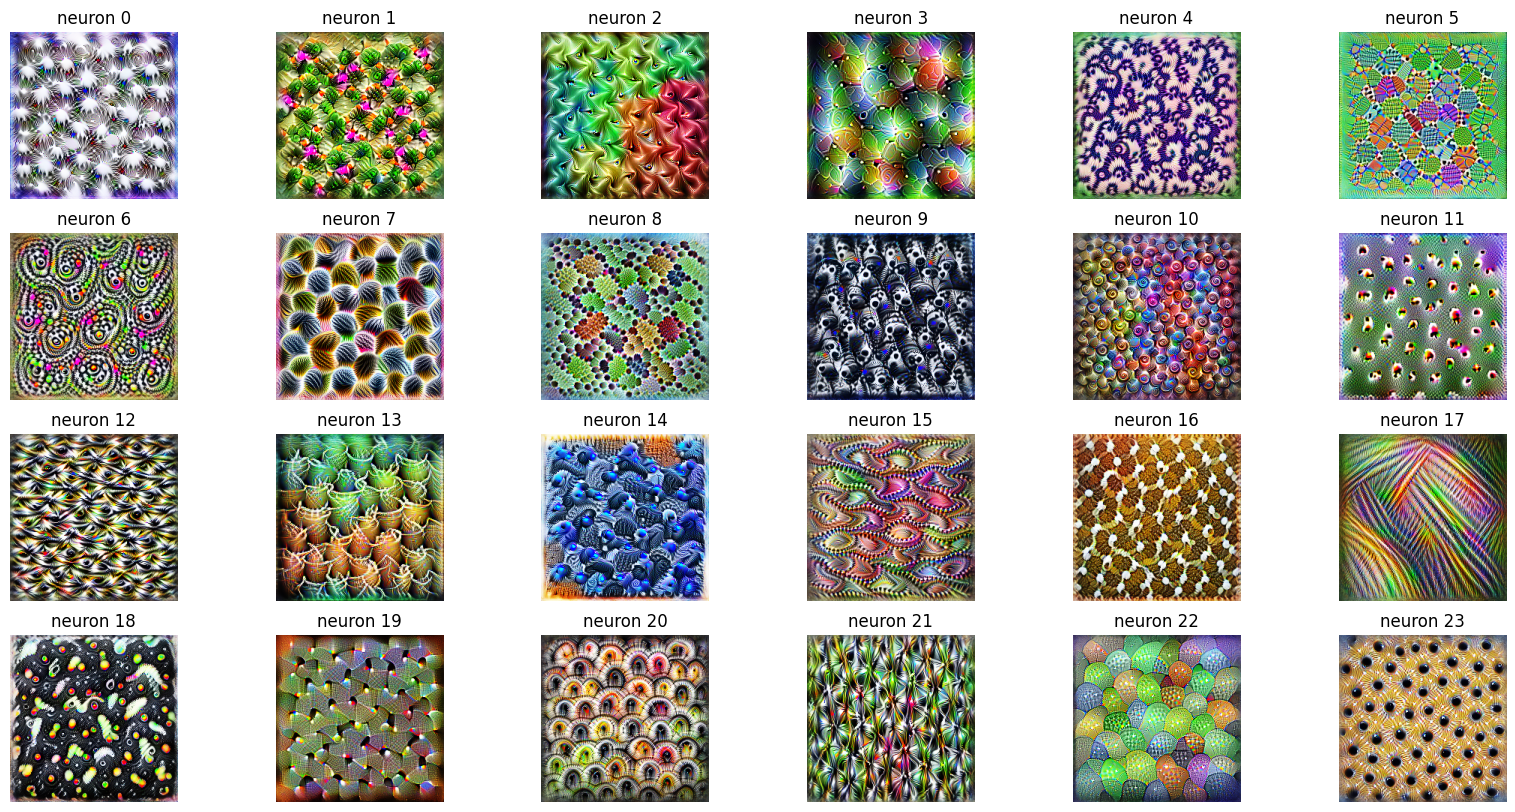

In [ ]:
n = 24
obj = sum(channel(layer, i, batch=i) for i in range(24))
x = ImageParam.new((24, 3, 224, 224), fft=True, decorr=True)
tfms = default_transforms(224) + [to_inception()]

vis = Visualizer(model, obj, x, tfms = tfms)
res = vis.visualize(n_iter=1000, param_kwargs={'dp':1})
axes = plt.subplots(4,6, figsize=(20,10))[1].flatten()
for i, ax in enumerate(axes):
    res[i].show(ax=ax, dp=1)
    ax.axis('off')
    ax.set_title(f'neuron {i}')